In [ ]:
import re
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from scipy.stats import pearsonr
from datetime import datetime
import seaborn as sns

data_path = './../../../data'

In [ ]:
rb_dir = os.path.join(data_path, 'RateBeer')
rev_with_scores_rb = pd.read_pickle(os.path.join(rb_dir, 'rev_w_scores.pkl'))
rev_with_scores_rb['date'] = pd.to_datetime(rev_with_scores_rb['date'])
beers_rb = pd.read_csv(os.path.join(rb_dir, 'beers.csv'))
users = pd.read_csv(os.path.join(rb_dir, 'users_RB_clean.csv'))
rev_with_scores_rb.columns = ['aroma_rt' if i == 10 else col for i, col in enumerate(rev_with_scores_rb.columns)]
rev_with_scores_rb.columns = ['appearance_rt' if i == 9 else col for i, col in enumerate(rev_with_scores_rb.columns)]

In [3]:
col_to_keep = ['beer_id', 'flavor', 'aroma', 'mouthfeel', 'brewing', 'technical', 
               'appearance', 'judgment', 'off_flavors', 'miscellaneous', 'expertness_score']
subset_data = rev_with_scores_rb[col_to_keep]
scores_for_beer = subset_data.groupby('beer_id').agg(['mean', 'std'])

# Add review count explicitly
scores_for_beer['review_count'] = rev_with_scores_rb.groupby('beer_id').size()

# Filter for review count > 1
scores_for_beer = scores_for_beer[scores_for_beer['review_count'] > 1]


In [4]:
col_to_keep = ['beer_id', 'flavor', 'aroma', 'mouthfeel', 'brewing', 'technical', 'appearance', 'judgment','off_flavors', 'miscellaneous', 'expertness_score']

mean_scores_beer = subset_data.groupby('beer_id').mean()
mean_scores_beer['review_count'] =subset_data.groupby('beer_id').size()
complete_beer = pd.merge(beers_rb, mean_scores_beer, on='beer_id')

In [5]:
col_to_keep = ['style','flavor', 'aroma', 'mouthfeel', 'brewing', 'technical', 'appearance', 'judgment','off_flavors', 'miscellaneous', 'expertness_score', 'review_count']

beer_gr = complete_beer[col_to_keep].groupby('style').mean()

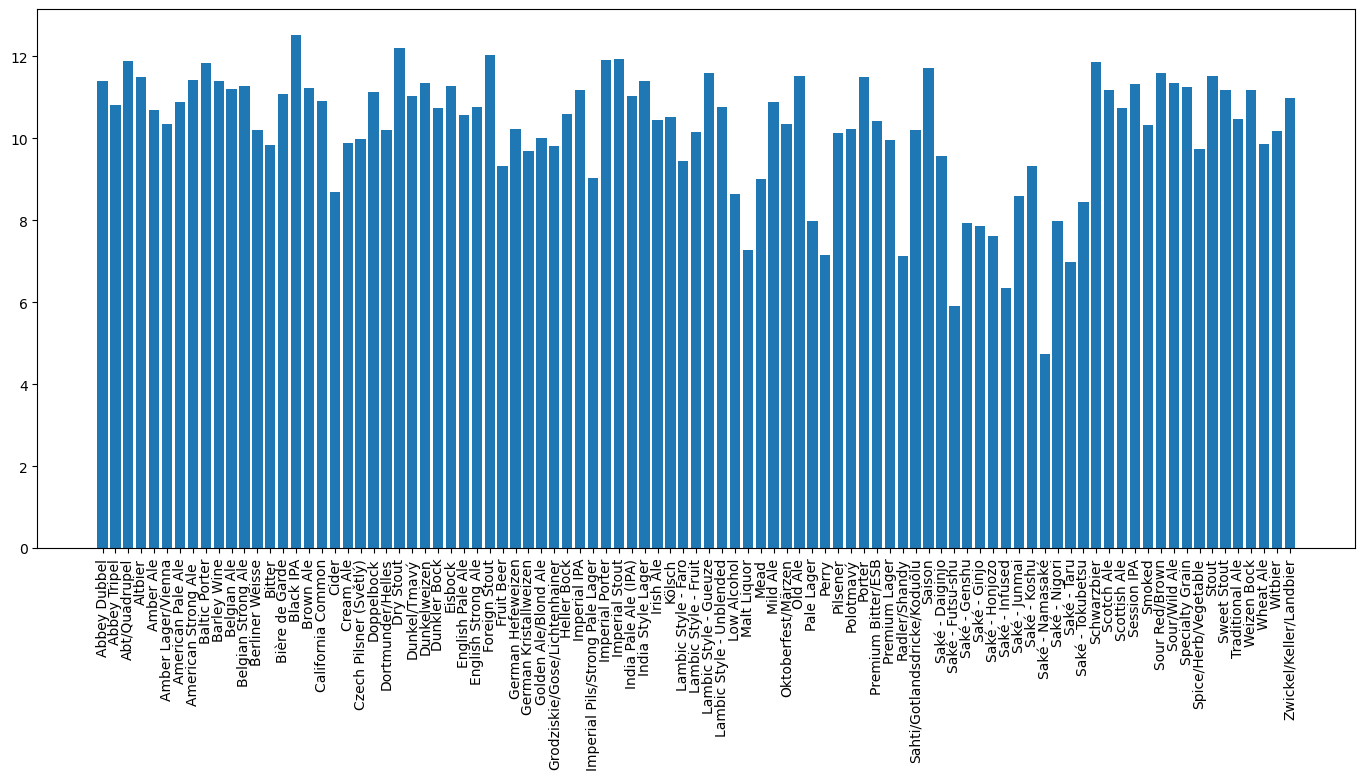

In [6]:
fig  = plt.figure(figsize=(17,7))
plt.bar(beer_gr.index, beer_gr['expertness_score'])

plt.xticks(rotation=90)
plt.show()

In [7]:
mean_scores_beer['review_count'].corr(mean_scores_beer['expertness_score'])

-0.014185687081408613

In [30]:
col_to_keep = ['user_id','flavor', 'aroma', 'mouthfeel', 'brewing', 'technical', 'appearance', 'judgment','off_flavors', 'miscellaneous', 'expertness_score']
user_rb = rev_with_scores_rb[col_to_keep].groupby('user_id').mean()

user_rb['nbr_rev'] = rev_with_scores_rb.groupby('user_id').size()

<Axes: >

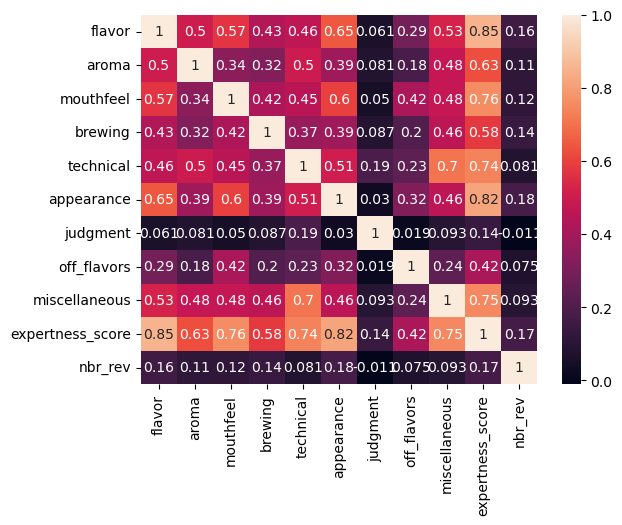

In [31]:
sns.heatmap(user_rb.corr(), annot=True)

<Axes: >

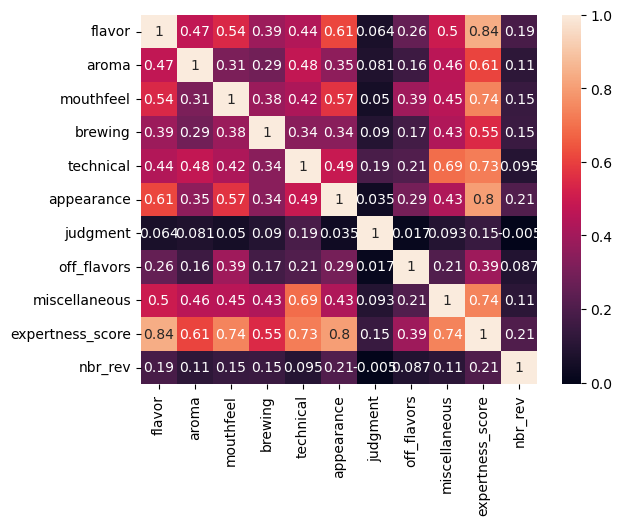

In [32]:
sns.heatmap(user_rb[user_rb['nbr_rev']<200].corr(), annot=True)

In [33]:
pearsonr(user_rb['expertness_score'], user_rb['nbr_rev'])

PearsonRResult(statistic=0.1742207106560048, pvalue=0.0)

In [34]:
def first_reviews(df, max=200):
    """
    Returns the earliest reviews for each user, up to a specified maximum.

    Parameters
    ----------
    df : DataFrame containing user review data, with 'user_id' and 'date' columns.
    max : Maximum number of reviews to return per user (default is 200).

    Returns
    -------
    DataFrame containing up to `max` earliest reviews per user, sorted by 'user_id' and 'date'.
    """

    df = df.sort_values(by=['user_id', 'date'])
    return df.groupby('user_id').head(max)

In [35]:
def joined_date_zero(reviews):
    """
    Normalizes review dates to the first review date for each user, setting their first review as day zero.

    Parameters
    ----------
    reviews : DataFrame containing user review data, with columns 'user_id' and 'date' (assumed to be datetime).

    Returns
    -------
        DataFrame where each user's review dates are adjusted relative to their first review date, 
        so that the first review date for each user is zero.

    Example
    -------
    >>> joined_date_zero(reviews)
    """
    fir_rev = first_reviews(reviews, max=1).rename(columns={'date': 'first_date'})
    reviews = reviews.merge(fir_rev[['user_id', 'first_date']], on='user_id')
    reviews['date'] = reviews['date'] - reviews['first_date'] 
    reviews = reviews.drop(columns=['first_date'])
    return reviews

In [36]:
# Normalizes review dates to the first review date for each user, setting their first review as day zero.
rev_zero_date= joined_date_zero(rev_with_scores_rb)

In [37]:
def standardize(x, y, cols):
    """
    Standardizes specified columns in DataFrame `x` based on means and standard deviations in DataFrame `y`.

    Parameters
    ----------
    x : DataFrame containing data to standardize, with 'beer_id' and columns to be standardized.
    y : DataFrame with 'beer_id' and statistical information for standardization, including means and standard deviations.
    cols : List of column names to standardize in `x`.

    Returns
    -------
        DataFrame `x` with specified columns standardized.
    """
    y_copy = y.drop(columns=['review_count'])
    y_copy.columns = ['beer_id'] + [f"{col}_{stat}" for col in cols for stat in ['mean', 'std']]

    x = x.merge(y_copy, on='beer_id')

    for col in cols:
        std = x[f"{col}_std"]
        x[col] = np.where(std != 0, (x[col] - x[f"{col}_mean"]) / std, x[col] - x[f"{col}_mean"])

    x = x.drop(columns=[f"{col}_mean" for col in cols])

    return x


In [38]:
col_to_keep = ['flavor', 'aroma', 'mouthfeel', 'brewing', 'technical', 'appearance', 'judgment','off_flavors', 'miscellaneous', 'expertness_score']

# Standardize the reviews score through the mean and the std of the scores for that particular beer 
rev_std = standardize(rev_zero_date, scores_for_beer.reset_index(), col_to_keep)

/var/folders/y0/lnx9fwjn5c75w4wndjtsp_4h0000gn/T/ipykernel_15700/233122733.py:15: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  y_copy = y.drop(columns=['review_count'])


In [39]:
def corr_and_count(group, att_1='expertness_score', replace_date=False):
    """
    Calculates the correlation between att_1 and 'date' within a given group, 
    along with the count of 'date' entries.

    Parameters
    ----------
    group :  A DataFrame group with columns att_1 and 'date'.
    att_1 : name of the first column
    replace_date : bool if True replace the date with an incremental counter

    Returns
    -------
    A Series containing:
        - 'correlation': The correlation between att_1 and 'date'. If the standard deviation 
          of either column is zero, the correlation is set to NaN.
        - 'total_count': The count of non-NaN entries in the 'date' column.

    """
    if(replace_date):
        group = group.sort_values(by='date')
        group['date'] = range(len(group))
        
    count = group['date'].count()
    if group[att_1].std() == 0 or group['date'].std() == 0 or len(group['date'])<2:
        correlation= float('nan') 
        p_value = float('nan')
    else:
        correlation, p_value = pearsonr(group[att_1], group['date'].astype(int))
    
    return pd.Series({'correlation': correlation,'p_value': p_value,  'total_count': count})



In [38]:
#result = rev_with_scores.groupby('user_id').apply(corr_and_count, include_groups=False)

In [19]:
# 
result = rev_std.groupby('user_id').apply(corr_and_count, include_groups=False)

/var/folders/y0/lnx9fwjn5c75w4wndjtsp_4h0000gn/T/ipykernel_15700/996315016.py:29: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(group[att_1], group['date'].astype(int))
/var/folders/y0/lnx9fwjn5c75w4wndjtsp_4h0000gn/T/ipykernel_15700/996315016.py:29: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(group[att_1], group['date'].astype(int))
/var/folders/y0/lnx9fwjn5c75w4wndjtsp_4h0000gn/T/ipykernel_15700/996315016.py:29: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(group[att_1], group['date'].astype(int))
/var/folders/y0/lnx9fwjn5c75w4wndjtsp_4h0000gn/T/ipykernel_15700/996315016.py:29: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(group[att_1], group['date'].astype(in

In [20]:
result = result.dropna()
result

,correlation,p_value,total_count
user_id,,,
2,-0.129591,0.374827,49.0
3,-0.050105,0.464867,215.0
7,-0.108085,0.506780,40.0
10,-0.930898,0.021578,5.0
20,-0.488058,0.003959,33.0
...,...,...,...
487194,0.000000,1.000000,2.0
487447,-1.000000,1.000000,2.0
487725,0.000000,1.000000,2.0


In [21]:
result[(result['total_count'] > 20) & (result['total_count'] < 500)]['correlation'].mean()

0.019990910692577357

In [22]:
result['correlation'].mean()

0.015579643055200432

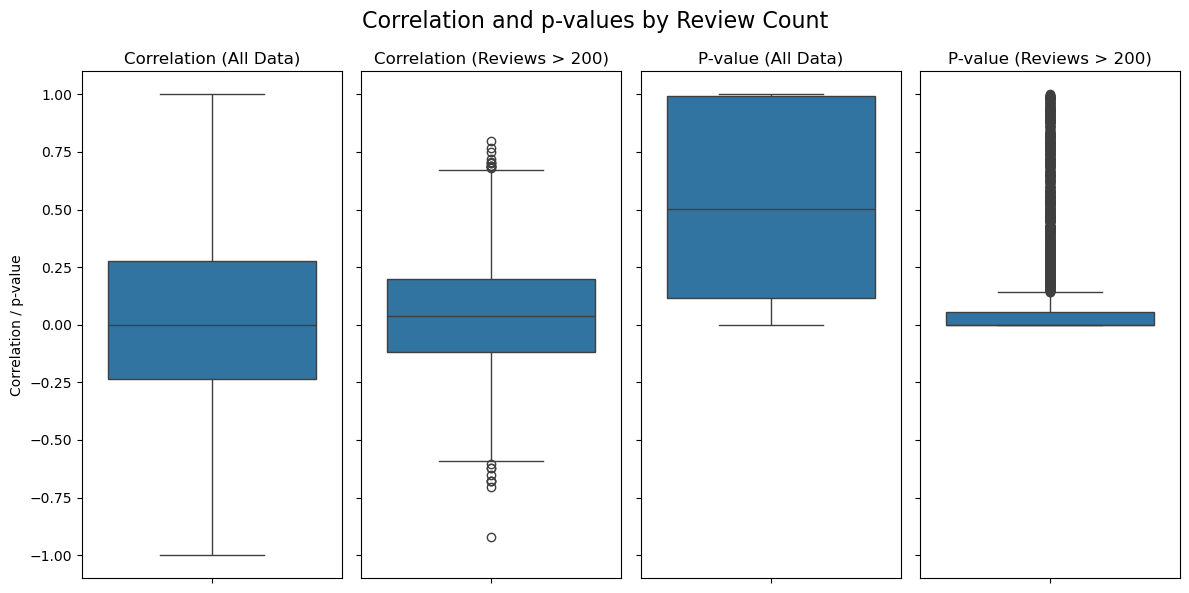

In [23]:
fig, axes = plt.subplots(1, 4, figsize=(12, 6), sharey = True) 


fig.suptitle("Correlation and p-values by Review Count", fontsize=16)
sns.boxplot(y=result['correlation'], ax=axes[0])
axes[0].set_title("Correlation (All Data)")
axes[0].set_ylabel("Correlation / p-value")

sns.boxplot(y=result[result['total_count'] > 200]['correlation'], ax=axes[1])
axes[1].set_title("Correlation (Reviews > 200)")

sns.boxplot(y=result['p_value'], ax=axes[2])
axes[2].set_title("P-value (All Data)")

sns.boxplot(y=result[result['total_count'] > 200]['p_value'], ax=axes[3])
axes[3].set_title("P-value (Reviews > 200)")

plt.tight_layout()  
plt.show()


In [40]:
users.columns

Index(['user_id', 'user_name', 'joined', 'location', 'nbr_ratings',
       'date_first_review'],
      dtype='object')

In [41]:
len(users[users['nbr_ratings']>200])

4425

In [42]:
def review_of_experts(df, users, nbr_rev=100):
    x = df.merge(users[['user_id','nbr_ratings']], on='user_id')
    return x[x['nbr_ratings']>nbr_rev]

In [43]:
rev_of_exp = review_of_experts(rev_with_scores_rb, users, nbr_rev=200)
rev_of_exp = first_reviews(rev_of_exp, max=100)
rev_exp_zero_date= joined_date_zero(rev_of_exp)

col_to_keep = ['flavor', 'aroma', 'mouthfeel', 'brewing', 'technical', 'appearance', 'judgment','off_flavors', 'miscellaneous', 'expertness_score']

rev_exp_std = standardize(rev_exp_zero_date, scores_for_beer.reset_index(), col_to_keep)
result = rev_exp_std.groupby('user_id').apply(corr_and_count, include_groups=False)

/var/folders/y0/lnx9fwjn5c75w4wndjtsp_4h0000gn/T/ipykernel_15700/233122733.py:15: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  y_copy = y.drop(columns=['review_count'])
/var/folders/y0/lnx9fwjn5c75w4wndjtsp_4h0000gn/T/ipykernel_15700/996315016.py:29: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(group[att_1], group['date'].astype(int))
/var/folders/y0/lnx9fwjn5c75w4wndjtsp_4h0000gn/T/ipykernel_15700/996315016.py:29: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(group[att_1], group['date'].astype(int))
/var/folders/y0/lnx9fwjn5c75w4wndjtsp_4h0000gn/T/ipykernel_15700/996315016.py:29: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(group[att_1], group['date'].astype(int))
/var/folder

In [44]:
result = result.dropna()

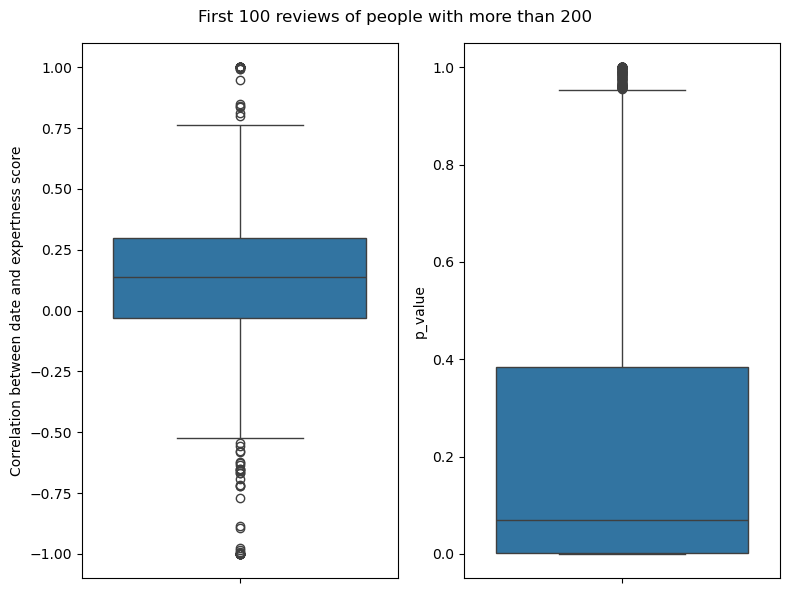

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(8, 6)) 

fig.suptitle('First 100 reviews of people with more than 200')

sns.boxplot(y=result['correlation'], ax=axes[0])

axes[0].set_ylabel("Correlation between date and expertness score")

sns.boxplot(y=result['p_value'], ax=axes[1])
axes[1].set_ylabel("p_value")

plt.tight_layout()  
plt.show()


In [46]:
result['correlation'].mean()

0.12786732359890723

In [47]:
rev_of_exp = review_of_experts(rev_with_scores_rb, users, nbr_rev=200)
rev_of_exp = first_reviews(rev_of_exp, max=5)

/var/folders/y0/lnx9fwjn5c75w4wndjtsp_4h0000gn/T/ipykernel_15700/233122733.py:15: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  y_copy = y.drop(columns=['review_count'])


Text(0.5, 1.0, 'Mean of the score (standardized) of the first 5 reviews of people with more than 200')

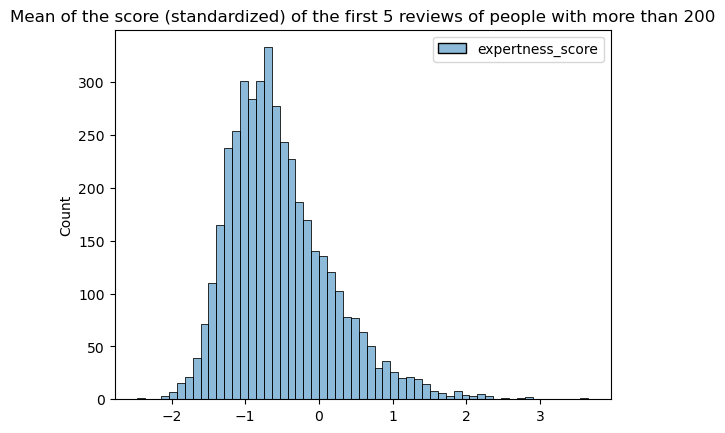

In [48]:
rev_exp_std = standardize(rev_of_exp, scores_for_beer.reset_index(), col_to_keep)
rev_exp_std_grouped = rev_exp_std.groupby('user_id')[['expertness_score']].agg('mean')
sns.histplot(rev_exp_std_grouped)
plt.title('Mean of the score (standardized) of the first 5 reviews of people with more than 200')

In [49]:
no_already_experts = rev_exp_std_grouped[rev_exp_std_grouped['expertness_score']<-0.5].index

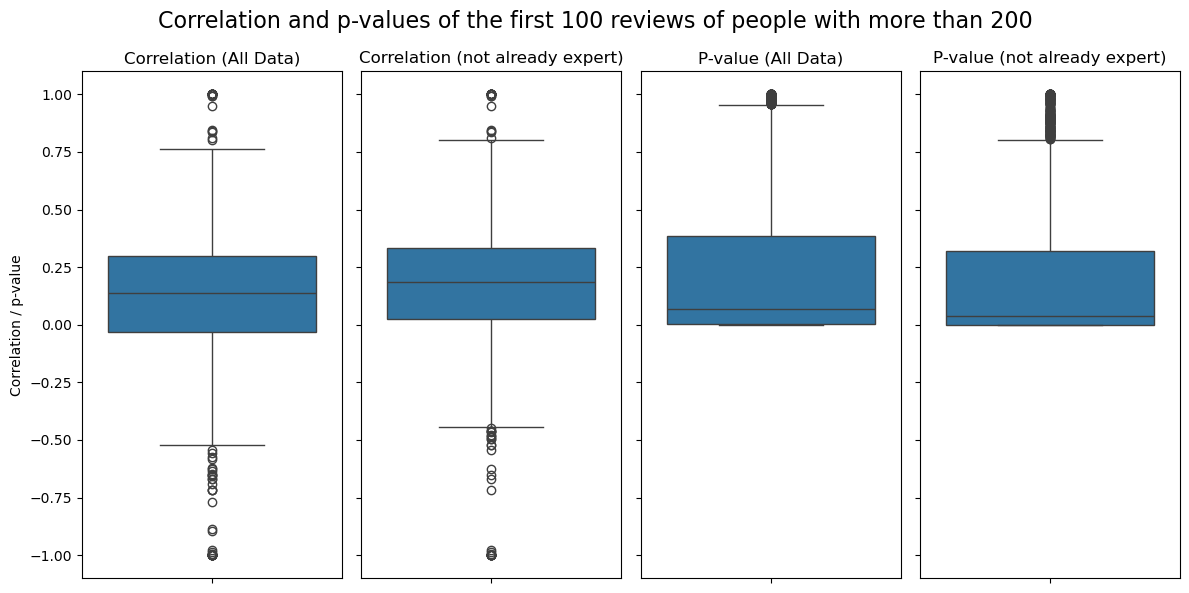

In [50]:
fig, axes = plt.subplots(1, 4, figsize=(12, 6), sharey = True) 

fig.suptitle("Correlation and p-values of the first 100 reviews of people with more than 200", fontsize=16)
sns.boxplot(y=result['correlation'], ax=axes[0])
axes[0].set_title("Correlation (All Data)")
axes[0].set_ylabel("Correlation / p-value")

sns.boxplot(y=result[result.index.isin(no_already_experts)]['correlation'], ax=axes[1])
axes[1].set_title("Correlation (not already expert)")

sns.boxplot(y=result['p_value'], ax=axes[2])
axes[2].set_title("P-value (All Data)")

sns.boxplot(y=result[result.index.isin(no_already_experts)]['p_value'], ax=axes[3])
axes[3].set_title("P-value (not already expert)")

plt.tight_layout()
plt.show()

In [51]:
result[result.index.isin(no_already_experts)].correlation.mean()

0.17140439594042256

In [52]:
result[result.index.isin(no_already_experts)].p_value.describe()

count    2.441000e+03
mean     1.982955e-01
std      2.814988e-01
min      4.052229e-28
25%      6.477848e-04
50%      3.852471e-02
75%      3.206397e-01
max      1.000000e+00
Name: p_value, dtype: float64

__Using and incremental count instead of the date__

In [53]:
col_to_keep = ['flavor', 'aroma', 'mouthfeel', 'brewing', 'technical', 'appearance', 'judgment','off_flavors', 'miscellaneous', 'expertness_score']

rev_exp_std = standardize(rev_with_scores_rb, scores_for_beer.reset_index(), col_to_keep)


/var/folders/y0/lnx9fwjn5c75w4wndjtsp_4h0000gn/T/ipykernel_15700/233122733.py:15: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  y_copy = y.drop(columns=['review_count'])


In [54]:
result_rep_date = rev_exp_std.groupby('user_id').apply(lambda group: corr_and_count(group, replace_date=True), include_groups=False)
result_rep_date = result_rep_date.dropna()

/var/folders/y0/lnx9fwjn5c75w4wndjtsp_4h0000gn/T/ipykernel_15700/996315016.py:29: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  correlation, p_value = pearsonr(group[att_1], group['date'].astype(int))
/var/folders/y0/lnx9fwjn5c75w4wndjtsp_4h0000gn/T/ipykernel_15700/996315016.py:29: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  correlation, p_value = pearsonr(group[att_1], group['date'].astype(int))


In [55]:
len(result_rep_date)

37552

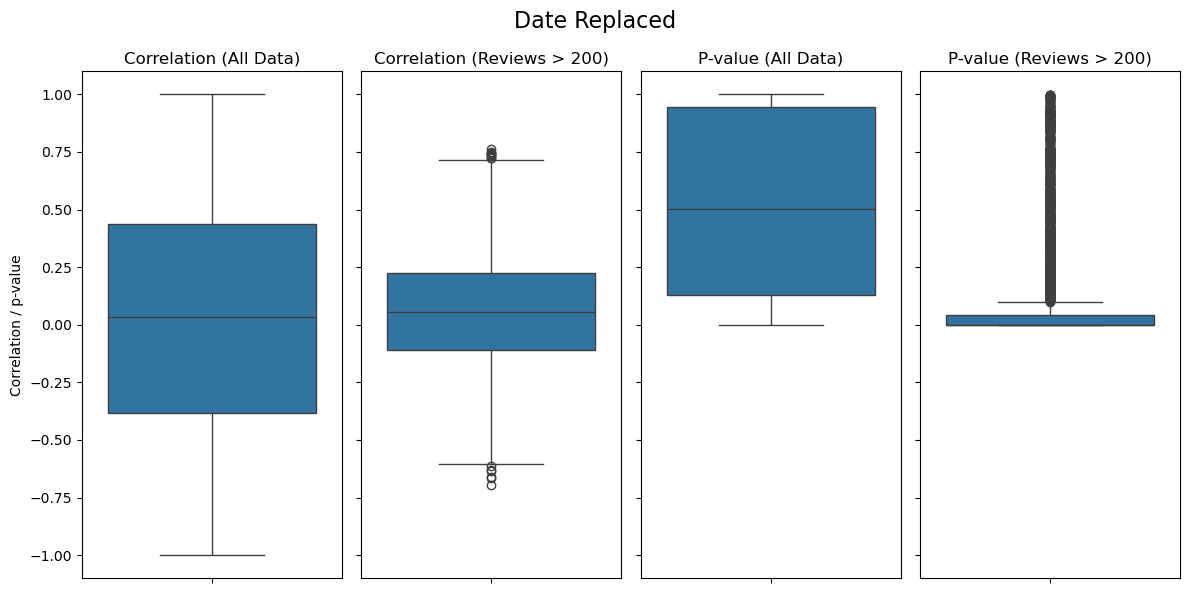

In [56]:
fig, axes = plt.subplots(1, 4, figsize=(12, 6), sharey = True) 

fig.suptitle('Date Replaced', fontsize=16)
sns.boxplot(y=result_rep_date['correlation'], ax=axes[0])
axes[0].set_title("Correlation (All Data)")
axes[0].set_ylabel("Correlation / p-value")

sns.boxplot(y=result_rep_date[result_rep_date['total_count'] > 200]['correlation'], ax=axes[1])
axes[1].set_title("Correlation (Reviews > 200)")

sns.boxplot(y=result_rep_date['p_value'], ax=axes[2])
axes[2].set_title("P-value (All Data)")

sns.boxplot(y=result_rep_date[result_rep_date['total_count'] > 200]['p_value'], ax=axes[3])
axes[3].set_title("P-value (Reviews > 200)")


plt.tight_layout()  
plt.show()

In [57]:
result_rep_date[(result_rep_date['total_count'] > 20) & (result_rep_date['total_count'] < 500)]['correlation'].mean()

0.04299520887379263

In [58]:
result_rep_date['correlation'].mean()

0.019757926481698038

In [59]:
rev_of_exp = review_of_experts(rev_with_scores_rb, users, nbr_rev=200)
rev_of_exp = first_reviews(rev_of_exp, max=100)

col_to_keep = ['flavor', 'aroma', 'mouthfeel', 'brewing', 'technical', 'appearance', 'judgment','off_flavors', 'miscellaneous', 'expertness_score']

rev_exp_std = standardize(rev_of_exp, scores_for_beer.reset_index(), col_to_keep)
result_rep_date = rev_exp_std.groupby('user_id').apply(lambda group: corr_and_count(group, replace_date=True), include_groups=False)
result_rep_date = result_rep_date.dropna()

/var/folders/y0/lnx9fwjn5c75w4wndjtsp_4h0000gn/T/ipykernel_15700/233122733.py:15: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  y_copy = y.drop(columns=['review_count'])


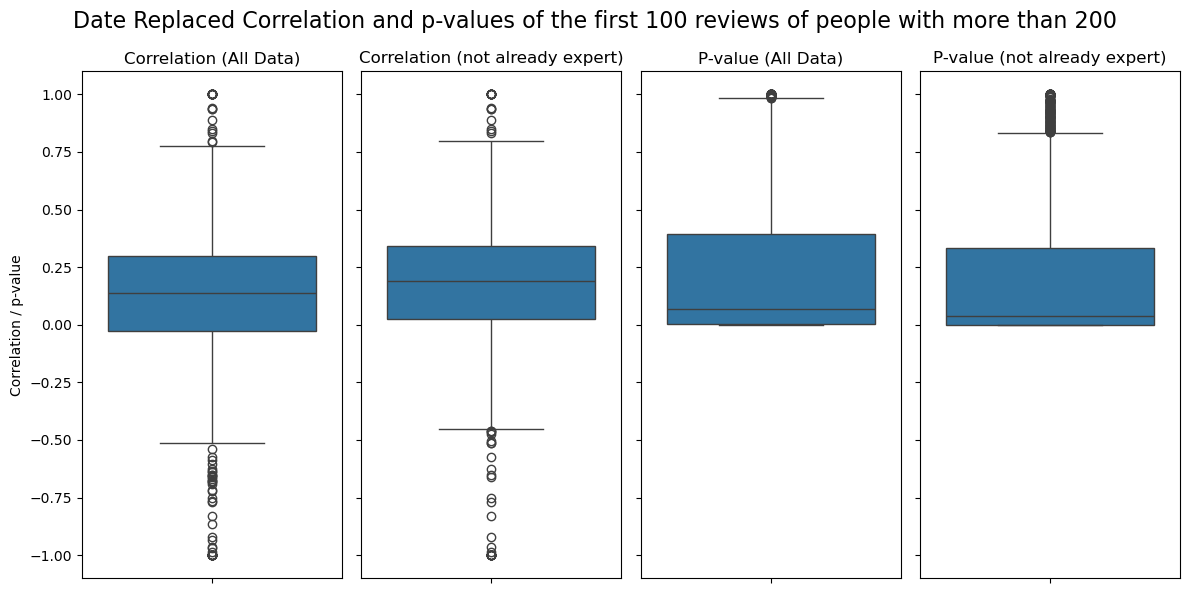

In [60]:
fig, axes = plt.subplots(1, 4, figsize=(12, 6), sharey=True) 


fig.suptitle("Date Replaced Correlation and p-values of the first 100 reviews of people with more than 200", fontsize=16)
sns.boxplot(y=result_rep_date['correlation'], ax=axes[0])
axes[0].set_title("Correlation (All Data)")
axes[0].set_ylabel("Correlation / p-value")

sns.boxplot(y=result_rep_date[result_rep_date.index.isin(no_already_experts)]['correlation'], ax=axes[1])
axes[1].set_title("Correlation (not already expert)")

sns.boxplot(y=result_rep_date['p_value'], ax=axes[2])
axes[2].set_title("P-value (All Data)")

sns.boxplot(y=result_rep_date[result_rep_date.index.isin(no_already_experts)]['p_value'], ax=axes[3])
axes[3].set_title("P-value (not already expert)")

plt.tight_layout()
plt.show()

In [61]:
result_rep_date[result_rep_date.index.isin(no_already_experts)].correlation.mean()

0.1752506714124958

In [62]:
result_rep_date.correlation.mean()

0.1319259833458273

In [63]:
result_rep_date[result_rep_date.index.isin(no_already_experts)].p_value.describe()

count    2.451000e+03
mean     2.039918e-01
std      2.876356e-01
min      5.028962e-28
25%      5.634251e-04
50%      3.799205e-02
75%      3.341174e-01
max      1.000000e+00
Name: p_value, dtype: float64